In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_addons as tfa
import matplotlib.pyplot as plt

from packages.DataAugmentation import dataAugmentation
from packages.DataProcessing import tfrecords
from packages.Model_CNN import get_model

plt.style.use('_mpl-gallery')

Your GPU may run slowly with dtype policy mixed_float16 because it does not have compute capability of at least 7.0. Your GPU:
  NVIDIA GeForce GTX 1050, compute capability 6.1
See https://developer.nvidia.com/cuda-gpus for a list of GPUs and their compute capabilities.
If you will use compatible GPU(s) not attached to this host, e.g. by running a multi-worker model, you can ignore this warning. This message will only be logged once


In [2]:
N_SPLITS = 4
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 16
EPOCHS = 100
PATIENCE = 10
MAX_LR = 1e-4
MIN_LR = 1e-6

In [3]:
class_names = np.load("./output/class_names.npy", allow_pickle=True)
num_classes = len(class_names)

In [4]:
train_target = np.load("./output/train_target.npy", allow_pickle=True)
valid_target = np.load("./output/valid_target.npy", allow_pickle=True)

In [5]:
# Reading TFRecords
records = tfrecords(IMG_HEIGHT, IMG_WIDTH)
train_ds = records.get_dataset(f'./output/tfrecords_{IMG_HEIGHT}_{IMG_WIDTH}/train.tfrecords')
valid_ds = records.get_dataset(f'./output/tfrecords_{IMG_HEIGHT}_{IMG_WIDTH}/valid.tfrecords')

In [6]:
# Data augmentation
aug_train = dataAugmentation()
train_ds = train_ds.map(aug_train.augment_iamge, num_parallel_calls=tf.data.AUTOTUNE)

In [7]:
train_ds = train_ds.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE).repeat()
valid_ds = valid_ds.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE).repeat()

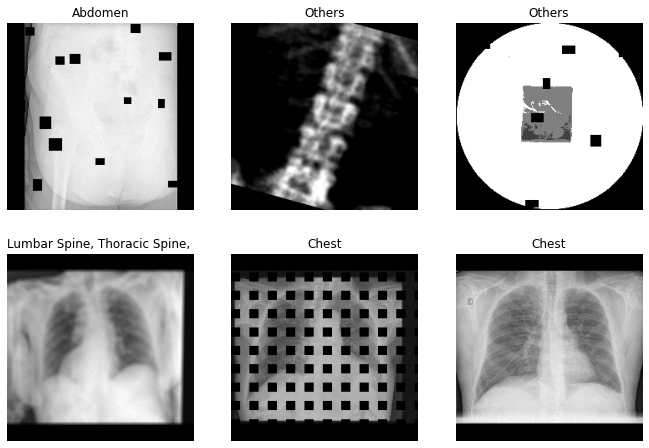

In [8]:
image_batch, label_batch = next(iter(train_ds))
plt.figure(figsize=(9, 6))
for i in range(6):
    ax = plt.subplot(2, 3, i + 1)
    plt.imshow(image_batch[i].numpy().reshape(IMG_HEIGHT, IMG_WIDTH), cmap='gray')
    label = label_batch[i].numpy()
    if label.sum() == 1:
        plt.title(class_names[np.argmax(label)])
    else:
        titles = ""
        for j in np.where(label == 1)[0]:
            titles = titles + class_names[j] + ", "
        plt.title(titles)
    plt.axis("off")
plt.show()

In [9]:
# Build Model

model = get_model(input_shape=(IMG_HEIGHT, IMG_WIDTH, 1), output_shape=num_classes)

In [10]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 1)]     0         
                                                                 
 rescaling (Rescaling)       (None, 224, 224, 1)       0         
                                                                 
 conv2d (Conv2D)             (None, 222, 222, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 111, 111, 32)     128       
 ormalization)                                                   
                                                                 
 re_lu (ReLU)                (None, 111, 111, 32)      0     

In [11]:
train_counts = train_target.sum(axis=0)

weight = (1/train_counts) * (len(train_target)/num_classes)
class_weight = {i:weight[i] for i in range(len(weight))}

In [12]:
steps_per_epoch = len(train_target)//BATCH_SIZE
validation_steps = len(valid_target)//BATCH_SIZE

In [13]:
model.compile(optimizer=tfa.optimizers.RectifiedAdam(learning_rate=MAX_LR,
                                                     total_steps=EPOCHS*steps_per_epoch,
                                                     warmup_proportion=0.2,
                                                     min_lr=MIN_LR), 
              loss=tf.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

In [14]:
my_callbacks = tf.keras.callbacks.EarlyStopping(patience=PATIENCE, 
                                                monitor='val_loss', 
                                                restore_best_weights=True)

In [15]:
history = model.fit(train_ds, 
                    validation_data=valid_ds,
                    epochs=EPOCHS,
                    callbacks=[my_callbacks],
                    class_weight=class_weight,
                    steps_per_epoch=steps_per_epoch,
                    validation_steps=validation_steps)

Epoch 1/80
86/86 [==============================] - 18s 142ms/step - loss: 3.4306 - accuracy: 0.0189 - val_loss: 3.3058 - val_accuracy: 0.0417
Epoch 2/80
86/86 [==============================] - 11s 123ms/step - loss: 3.3424 - accuracy: 0.0160 - val_loss: 3.3003 - val_accuracy: 0.0089
Epoch 3/80
86/86 [==============================] - 12s 135ms/step - loss: 3.2655 - accuracy: 0.0175 - val_loss: 3.3282 - val_accuracy: 0.0089
Epoch 4/80
86/86 [==============================] - 13s 147ms/step - loss: 3.1898 - accuracy: 0.0298 - val_loss: 3.3355 - val_accuracy: 0.0089
Epoch 5/80
86/86 [==============================] - 11s 129ms/step - loss: 3.1592 - accuracy: 0.0349 - val_loss: 3.2827 - val_accuracy: 0.0089
Epoch 6/80
86/86 [==============================] - 11s 130ms/step - loss: 3.0157 - accuracy: 0.0415 - val_loss: 3.2120 - val_accuracy: 0.0268
Epoch 7/80
86/86 [==============================] - 11s 131ms/step - loss: 2.9832 - accuracy: 0.0531 - val_loss: 3.1293 - val_accuracy: 0.0268

In [16]:
model.save(f'./output/models/model_CNN.h5')

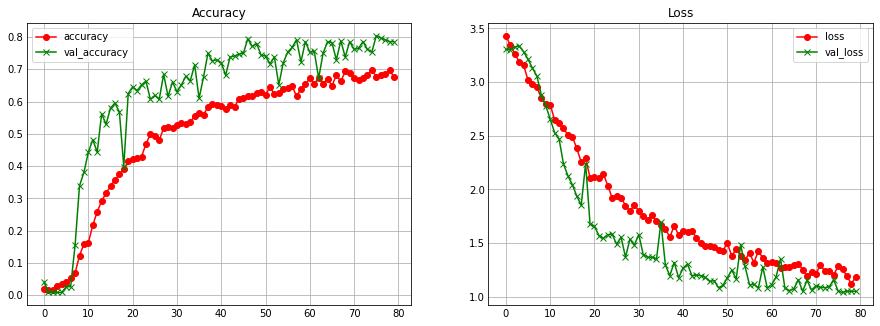

In [17]:
# Validate the Model

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.set_title('Accuracy')
ax1.plot(history.history['accuracy'], 'r', marker="o", label='accuracy')
ax1.plot(history.history['val_accuracy'], 'g', marker="x", label='val_accuracy')
ax1.legend()

ax2.set_title('Loss')
ax2.plot(history.history['loss'], 'r', marker="o", label='loss')
ax2.plot(history.history['val_loss'], 'g', marker="x", label='val_loss')
ax2.legend()

plt.show()

In [18]:
# Reading TFRecords
test_ds = records.get_test_dataset(f'./output/tfrecords_{IMG_HEIGHT}_{IMG_WIDTH}/test.tfrecords')

In [19]:
# Prediction
test_ds = test_ds.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)
pred = model.predict(test_ds)

In [20]:
# Submission
df_test = pd.read_csv("./input/sample_submission.csv")
df_test.Target = np.argmax(pred, axis=1)
df_test.to_csv("./output/submission.csv", index=False)